In [3]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(tf.test.is_gpu_available())




False


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`.

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_clean_noisy = 10000

imgs = np.empty((n_clean_noisy,32,32,3))

# load the labels
clean_labels = np.genfromtxt('/content/test_labels.csv', delimiter=',', dtype="int8")


For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset.

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [5]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(imgs)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]

    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0]
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]

    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

ValueError: maximum supported dimension for an ndarray is 32, found 10000

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

### 2.2. Model I

In [7]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.1, random_state=42)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    if os.path.exists('./model_I.h5'):
        models.load_model('./model_I.h5')

        image = np.expand_dims(image, axis=0)

        pred = model.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        model.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_I = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

        test_loss_I, test_acc_I = model.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_I}, Test Accuracy: {test_acc_I}")

        model.save('./model_I.h5')

        plt.plot(history_I.history['accuracy'])
        plt.plot(history_I.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history_I.history['loss'])
        plt.plot(history_I.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        image = np.expand_dims(image, axis=0)

        pred = model.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

### 2.3. Model II

In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.3, random_state=42)

    # Prepossessing data
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Create the Data Augmentation Tool
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Data augmentation of the training set
    datagen.fit(X_train)

    model_II = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])


    if os.path.exists('./model_II.h5'):
        models.load_model('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        # model_II.compile(optimizer='adam',
        #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #                  metrics=['accuracy'])

        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        model_II.compile(optimizer=sgd_optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_II = model_II.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=10,
                     validation_data=(X_test, y_test))


        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        plt.plot(history_II.history['accuracy'])
        plt.plot(history_II.history['val_accuracy'])
        plt.title('Mode2 accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history_II.history['loss'])
        plt.plot(history_II.history['val_loss'])
        plt.title('Mode2 loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        model_II.save('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose.

In [9]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
#model1-eval
n_test = 1000
test_labels = np.genfromtxt('/content/test_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))

evaluation(model_I, test_labels, test_imgs)

1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 88ms/step


KeyboardInterrupt: 

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


219/219 [==============================] - 210s 953ms/step - loss: 2.3033 - accuracy: 0.0989 - val_loss: 2.3053 - val_accuracy: 0.0937
Epoch 2/10
219/219 [==============================] - 201s 920ms/step - loss: 2.3035 - accuracy: 0.0983 - val_loss: 2.3043 - val_accuracy: 0.0937
Epoch 3/10
219/219 [==============================] - 199s 910ms/step - loss: 2.3034 - accuracy: 0.0971 - val_loss: 2.3044 - val_accuracy: 0.0930
Epoch 4/10
219/219 [==============================] - 194s 887ms/step - loss: 2.3032 - accuracy: 0.0950 - val_loss: 2.3052 - val_accuracy: 0.0937
Epoch 5/10
219/219 [==============================] - 197s 898ms/step - loss: 2.3034 - accuracy: 0.1021 - val_loss: 2.3036 - val_accuracy: 0.1027
Epoch 6/10
219/219 [==============================] - 194s 883ms/step - loss: 2.3033 - accuracy: 0.0989 - val_loss: 2.3040 - val_accuracy: 0.0930
Epoch 7/10
219/219 [==============================] - 193s 884ms/step - loss: 2.3033 - accuracy: 0.0953 - val_loss: 2.3044 - val_accura

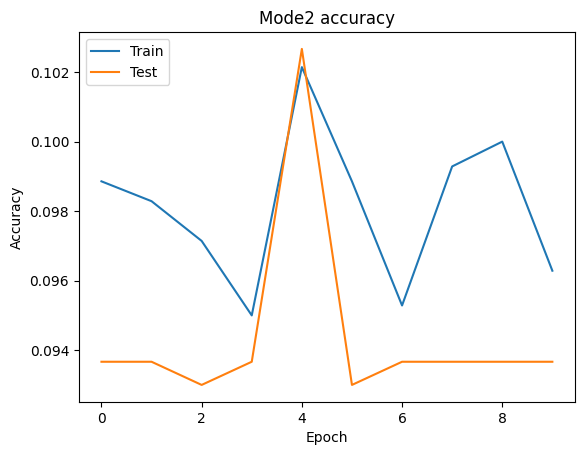

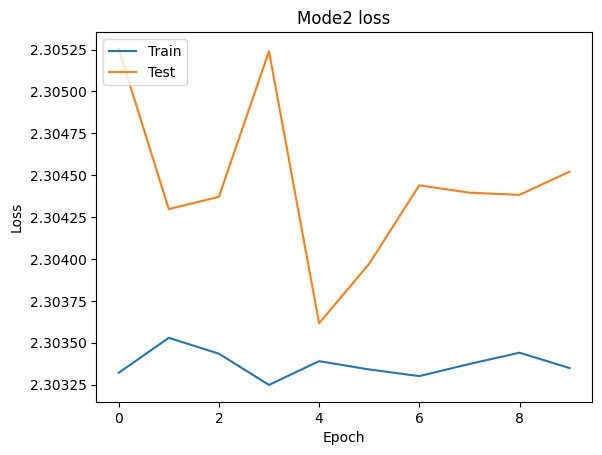

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py:103: RuntimeWarning: overflow encountered in cast
  return ops.EagerTensor(value, ctx.device_name, dtype)


1/1 [==============================] - 0s 172ms/step


KeyboardInterrupt: 

In [11]:
#model2-eval
n_test = 1000
test_labels = np.genfromtxt('/content/test_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))

evaluation(model_II, test_labels, test_imgs)